<a href="https://colab.research.google.com/github/AmritSDutta/colab_ml/blob/main/PytorchGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import random

Check MultivariateNormal

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if using multi-GPU

    # Ensures deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [3]:
set_seed(42)

In [46]:
device = 'cuda' if torch.accelerator.is_available() else 'cpu'
latent_dimension = 49
batch_size=8184
print(device)

cuda


In [47]:
data = torch.utils.data.DataLoader(
        torchvision.datasets.FashionMNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=batch_size,
        shuffle=True,  drop_last=True)

In [48]:
train_dataset = torchvision.datasets.FashionMNIST(root='data', train=True, transform=torchvision.transforms.ToTensor())

train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [49]:
test_dataset = torchvision.datasets.FashionMNIST(root='data', train=False, transform=torchvision.transforms.ToTensor())

test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=True)

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.first = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.AvgPool2d(kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.AvgPool2d(kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(256, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )


    def forward(self, x):
            x= self.first(x)
            x = x.reshape((-1, 256))
            logit = self.classifier(x)
            return logit

In [9]:
discrim = Discriminator()
print(discrim)
logit = discrim(torch.randn(1,1,28,28))
print(logit)

Discriminator(
  (first): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): AvgPool2d(kernel_size=3, stride=2, padding=1)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): AvgPool2d(kernel_size=3, stride=2, padding=1)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
tensor([[0.4922]], grad_fn=<SigmoidBackward0>)


In [10]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.first = nn.Sequential(
            nn.Linear(latent_dim, 392),
            nn.LeakyReLU(),
            nn.Linear(392, 784),
            nn.Tanh()
        )

    def forward(self, x):
        x= self.first(x)
        decoded = x
        return decoded.reshape((-1, 1, 28, 28))


Generator(
  (first): Sequential(
    (0): Linear(in_features=49, out_features=392, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=392, out_features=784, bias=True)
    (3): Tanh()
  )
)
torch.Size([1, 1, 28, 28])


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

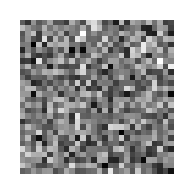

In [45]:
genee = Generator(latent_dimension)
print(genee)
generated = genee(torch.randn_like( torch.Tensor(latent_dimension)))
print(generated.shape)

fig, axes = plt.subplots(1, 1, figsize=(3, 1))
axes.imshow(generated.cpu().detach().numpy().squeeze(), cmap='gray')
axes.axis('off')

In [12]:
class Gan(nn.Module):
    def __init__(self, latent_dim):
        super(Gan, self).__init__()
        self.generator = Generator(latent_dimension)
        self.discriminator = Discriminator()

    def forward(self, x):
        generated = self.generator(x)
        predicted = self.discriminator(generated) # we are using only the sample generated from mu and sigma , not original image
        return predicted


In [13]:
def prepare_data_for_discrimator_training(generator_model: nn.Module, X, y):
    X = X.to(device)
    yy = torch.ones(batch_size, 1).to(device)

    input_to_generator = torch.randn(batch_size, latent_dimension).to(device)
    output_from_generator = generator_model(input_to_generator).to(device)
    level_for_generator_output = torch.zeros(batch_size, 1).to(device)

    # Concatenate real and fake images
    combined_X = torch.cat((X, output_from_generator), dim=0)
    # Concatenate real and fake labels
    combined_yy = torch.cat((yy, level_for_generator_output), dim=0)
    #X.append(output_from_generator)
    #yy.append(level_for_generator_output)

    # Generate a permutation of indices
    indices = torch.randperm(combined_X.size(0))

    # Apply permutation to both tensors
    x_shuffled = combined_X[indices]
    y_shuffled = combined_yy[indices]
    return x_shuffled, y_shuffled, input_to_generator, level_for_generator_output


In [14]:
set_seed(42)

In [32]:
def train(model, data, epochs=5):
    opt = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0001)
    loss_fn = nn.BCELoss()
    model.to(device)
    print(f'total data: {len(data)}')
    print(f'batch size: {batch_size}')

    for epoch in range(epochs):
        for index, (x, y) in enumerate(data):
            model.train()
            model.generator.eval()
            model.discriminator.train()
            x_shuffled, y_shuffled, noise, noise_levels = prepare_data_for_discrimator_training(model.generator,x,y)
            output_from_discriminator = model.discriminator(x_shuffled)
            opt.zero_grad()
            discriminator_loss = loss_fn(output_from_discriminator, y_shuffled)
            discriminator_loss.backward()
            opt.step()
            model.eval()

            model.train()
            model.generator.train()
            model.discriminator.eval()
            output_from_gan = model(noise)
            opt.zero_grad()
            gan_loss = loss_fn(output_from_gan, torch.zeros(batch_size, 1).to(device))
            gan_loss.backward()
            opt.step()
            model.eval()
            print(f'GAN batch: {index} , batch size:  {len(x)}, discriminator loss: {discriminator_loss},  gan loss: {gan_loss} ')


        print(f'\n ## Batch final Dicriminator epoch: {epoch} , loss: {discriminator_loss}, GAN loss: {gan_loss} \n')


    model.generator.eval()
    model.discriminator.eval()
    return model

In [50]:
set_seed(42)
latent_dims = 49
gan_model = Gan(latent_dimension).to(device)
trained_gan = train(gan_model, data, 15)

total data: 7
batch size: 8184
GAN batch: 0 , batch size:  8184, discriminator loss: 0.6924477219581604,  gan loss: 0.6761325597763062 
GAN batch: 1 , batch size:  8184, discriminator loss: 0.6914271116256714,  gan loss: 0.6742154359817505 
GAN batch: 2 , batch size:  8184, discriminator loss: 0.6906837224960327,  gan loss: 0.6723543405532837 
GAN batch: 3 , batch size:  8184, discriminator loss: 0.6899937987327576,  gan loss: 0.6705058813095093 
GAN batch: 4 , batch size:  8184, discriminator loss: 0.6893044710159302,  gan loss: 0.6686479449272156 
GAN batch: 5 , batch size:  8184, discriminator loss: 0.6886362433433533,  gan loss: 0.6667891144752502 
GAN batch: 6 , batch size:  8184, discriminator loss: 0.6879090666770935,  gan loss: 0.6649323105812073 

 ## Batch final Dicriminator epoch: 0 , loss: 0.6879090666770935, GAN loss: 0.6649323105812073 

GAN batch: 0 , batch size:  8184, discriminator loss: 0.6872326135635376,  gan loss: 0.6631740927696228 
GAN batch: 1 , batch size:  818

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

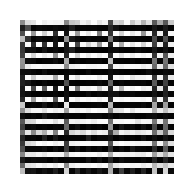

In [53]:
torch.manual_seed(random.randint(1, 150))
noise_vector = torch.randn(1, latent_dimension).to(device)
generated_image = trained_gan.generator(noise_vector)

fig, axes = plt.subplots(1, 1, figsize=(3, 1))
axes.imshow(generated_image.cpu().detach().numpy().squeeze(), cmap='gray')
axes.axis('off')